In [1]:
import torch
from torch import Tensor, nn
from torch.optim import Adam, Optimizer
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import IterableDataset
import torchvision

from pytorch_lightning import LightningModule, Trainer
import segmentation_models_pytorch as smp

import kornia as K
import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from PIL import Image

import cv2
import re
import ctypes
import multiprocessing as mp

import random
import os

%matplotlib inline

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

list_train = os.listdir('transformed_mask/train')
list_val = os.listdir('transformed_mask/val')

In [15]:
list_train = ['train/' + string for string in list_train]
list_val = ['val/' + string for string in list_val]

In [16]:
list_val[5]

'val/14000_2000.png'

In [17]:
# img = cv2.imread(f'transformed_image/{list_val[5]}')
# target = cv2.imread(f'transformed_mask/{list_val[5]}')
# img = torch.from_numpy(img)
# target = torch.from_numpy(target)
# img = img.permute(2, 0, 1)
# img = img.unsqueeze(0).float()
# target = target.permute(2, 0, 1)
# target = target.unsqueeze(0).float()
# img.shape, target.shape 

In [18]:
img = torchvision.io.read_image(f'transformed_image/{list_val[5]}')
target = torchvision.io.read_image(f'transformed_mask/{list_val[5]}')
img = img.unsqueeze(0).float()
target = target.unsqueeze(0).float()
img.shape, target.shape 

(torch.Size([1, 3, 2370, 3000]), torch.Size([1, 3, 2370, 3000]))

In [31]:
# define some augmentations
class Preprocessing(nn.Module):
    # to dataloader
    _preprocess =  K.augmentation.AugmentationSequential(
    K.augmentation.RandomCrop((256,256)),
    data_keys=['input', 'mask']
    )

    def __init__(self):
        super(Preprocessing, self).__init__()
        
    @torch.no_grad()
    def forward(self, img: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        x, y = self.preprocess(img, mask)
        return x.to(device), y.to(device)

    def preprocess(self, img: torch.Tensor, mask: torch.Tensor) -> dict:
        return self._preprocess(img, mask)


class Augmentation(nn.Module):
    # to SegModel
    _augmentations = K.augmentation.AugmentationSequential(
    K.augmentation.RandomHorizontalFlip(p=0.75),
    K.augmentation.RandomVerticalFlip(p=0.75),
    K.augmentation.RandomAffine(degrees=10.),
    K.augmentation.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    data_keys=['input', 'mask']
    )

    def __init__(self):
        super(Augmentation, self).__init__()

    @torch.no_grad()
    def forward(self, img: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        return self.augmentations(img, mask)

    def augmentations(self, img: torch.Tensor, mask: torch.Tensor) -> dict:
        x, y = self._augmentations(img, mask)
        return {"input": x, "target": y}


In [41]:
Pre = Preprocessing()
img_pre, target_pre = Pre(img/255., target/255.)

In [44]:
Aug = Augmentation()
new_dict = Aug.augmentations(img_pre, target_pre)

In [ ]:
new_dict

In [6]:
class GeoDataset(Dataset):
    def __init__(self,
    #  image, mask, 
     list_names, preprocess, c, h, w):
        # shared_array_base = mp.Array(ctypes.c_float, c*h*w)
        # shared_array = np.ctypeslib.as_array(shared_array_base.get_obj())
        # shared_array = shared_array.reshape(h, w, c)
        # self.shared_image = torch.from_numpy(shared_array)
        # self.shared_mask = torch.from_numpy(shared_array)
        self.shared_image = torch.zeros(h, w, c).share_memory_()
        self.shared_mask = torch.zeros(h, w ,c).share_memory_()
        self.transforms = preprocess
        self.list_names = list_names
        # self.get_img()
    def get_img(self,):
        if type(self.list_names) ==  list:
            name = random.choice(self.list_names)
            
        # print(name)
        # self.image = np.array(Image.open(f'transformed_image/{name}'))
        # self.mask = np.array(Image.open(f'transformed_mask/{name}'))
        image = cv2.imread(f'transformed_image/{name}')
        mask = cv2.imread(f'transformed_mask/{name}') 
        mask = mask / 255.
        # self.shared_image[:,:,:] = torch.from_numpy(image)
        # self.shared_mask[:,:,:] = torch.from_numpy(mask)
        self.shared_image = torch.from_numpy(image)
        self.shared_mask = torch.from_numpy(mask)



    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        if idx%10 == 0:
            self.get_img()
        # augmented = self.transforms(image=self.image, 
        #                             mask=self.mask)
 
        # image = augmented['image']
        # mask = augmented['mask']   
        return self.shared_image[:256, :256], self.shared_mask[:256, :256]

In [7]:
# class GeoDataset(Dataset):
#     def __init__(self,
#     #  image, mask, 
#      list_names, transforms):
#         # self.image = image.astype("float32")
#         # self.mask = mask.astype("float32")
#         self.transforms = transforms
#         self.list_names = list_names
#         self.get_img()
#     def get_img(self,):
#         if type(self.list_names) ==  list:
#             name = random.choice(self.list_names)
#         else:
#             name = self.list_names
#         # print(name)
#         # self.image = np.array(Image.open(f'transformed_image/{name}'))
#         # self.mask = np.array(Image.open(f'transformed_mask/{name}'))
#         self.image = cv2.imread(f'transformed_image/{name}')
#         self.mask = cv2.imread(f'transformed_mask/{name}') 
#         self.mask = self.mask / 255.



#     def __len__(self):
#         return 2000
    
#     def __getitem__(self, idx):
#         if idx%400 == 0:
#             self.get_img()
#         augmented = self.transforms(image=self.image, 
#                                     mask=self.mask)
 
#         image = augmented['image']
#         mask = augmented['mask']   
#         return image, mask

In [8]:
PATCH_SIZE = 256
transforms = A.Compose([
    A.RandomCrop(height=PATCH_SIZE, width=PATCH_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.2),
    A.Perspective(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

transforms_test = A.Compose([
    A.RandomCrop(height=PATCH_SIZE, width=PATCH_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [9]:
train_dataset = GeoDataset(
    # image=image_train, mask=mask_train, 
    transforms=transforms,
    list_names=list_train,
    c=3, h=3000, w=3000)
train_dataloader = DataLoader(train_dataset, batch_size=4, num_workers=4)
val_dataset = GeoDataset(
    # image=image_train, mask=mask_train, 
    transforms=transforms_test,
    list_names=list_val,
    c=3, h=3000, w=3000)
val_dataloader = DataLoader(val_dataset, batch_size=4, num_workers=4)

In [10]:
# img, msk = next(iter(train_dataloader))
for i, m in val_dataloader:
    print(i.shape)
    break


torch.Size([4, 256, 256, 3])


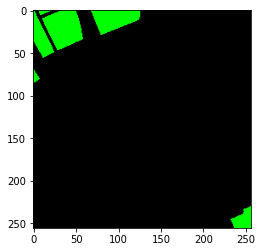

In [11]:
plt.imshow(m[0])

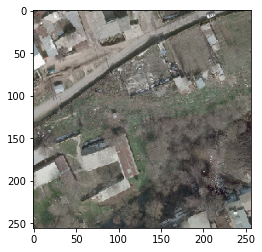

In [12]:
# plt.imshow(i[0].permute(1,2,0))
plt.imshow(i[0])

In [13]:
cross = nn.CrossEntropyLoss() 
# smp.losses.DiceLoss(mode='multiclass', )

In [14]:
class SemSegment(LightningModule):
    def __init__(
        self,
        lr: float = 0.001,
        num_classes: int = 3,
        bilinear: bool = False,
    ):
        super().__init__()

        self.bilinear = bilinear
        self.lr = lr
        self.net = smp.Unet(encoder_name='resnet18', classes=num_classes)
        self.dice = cross

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_nb):
        img, mask = batch
        img = img.float()
        mask = mask.float()
        out = self(img.permute(0, 3, 1, 2))
        # print(f'img size {img.shape}  out size {out.shape}  mask size {mask.shape}')
        loss_train_dice = self.dice(out, mask.permute(0, 3, 1, 2))
        # Логи тренировочных шагов для tensorboard
        self.log('train_dice_step', loss_train_dice, on_step=True)

        return {"loss": loss_train_dice, "log": loss_train_dice.detach(), "progress_bar": loss_train_dice.detach()}

    # def validation_step(self, batch, batch_idx):
    #     img, mask = batch
    #     img = img.float() 
    #     mask = mask.float()
    #     out = self(img.permute(0, 3, 1, 2))
    #     print(f'img size {img.shape}  out size {out.shape}  mask size {mask.shape}')
    #     loss_val_dice = self.dice(out, mask.permute(0, 3, 1, 2))
    #     # Логи валидационных шагов для tensorboard
    #     self.log('val_dice_step', loss_val_dice, on_step=True)

    #     return {"val_loss": loss_val_dice}


    # def validation_epoch_end(self, outputs):
    #     loss_val = torch.stack([x["val_loss"] for x in outputs]).mean()
    #     log_dict = {"val_loss": loss_val.detach()}
    #     # Логи валидационных эпох для tensorboard
    #     self.log('val_epoch_total_step', log_dict['val_loss'], on_epoch=True)

    #     return log_dict

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        return opt

In [15]:
model =SemSegment()

In [16]:
# from pytorch_lightning.callbacks import ModelCheckpoint

In [17]:
# checkpoint_callback = ModelCheckpoint(dirpath="lightning_logs/best", save_top_k=2, monitor="val_epoch_total_step")
trainer = Trainer(gpus=1, max_epochs=50,
#  callbacks=[checkpoint_callback]
 )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [18]:
trainer.fit(model,
 train_dataloader, val_dataloader,
)

/home/tims/miniconda3/envs/geo/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type             | Params
------------------------------------------
0 | net  | Unet             | 14.3 M
1 | dice | CrossEntropyLoss | 0     
------------------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
57.314    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/home/tims/miniconda3/envs/geo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
img, msk = next(iter(train_dataloader))
print(img.shape, msk.shape)

10000.png
torch.Size([1, 3, 512, 512]) torch.Size([1, 512, 512, 3])


In [ ]:
out = model(img.to('cuda'))
msk = msk.to('cuda')

In [ ]:
out[0].shape

torch.Size([3, 512, 512])

In [ ]:
# dice(out, msk.type(torch.long).permute(0, 3, 1, 2))
dice(out[0], msk[0].type(torch.float).permute(2, 0, 1))

tensor(486.6394, device='cuda:0', grad_fn=<DivBackward1>)